In [279]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import networkx as nx
import math
from scipy import sparse


In [280]:
%matplotlib inline

In [281]:
seed = 3

# Load the data

In [282]:
data_path = 'data/'

In [283]:
# Kaggle data
movies_path = data_path + 'tmdb-5000-movie-dataset/'
credits = pd.read_csv(movies_path + 'tmdb_5000_credits.csv')
movies = pd.read_csv(movies_path + 'tmdb_5000_movies.csv')

credits = credits.rename(columns={'movie_id': 'id'})

# merge the two data set credit and movies
movies = movies.merge(credits, how='inner', on='id')

movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# Clean and prepare the data

In [284]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [285]:
movies['earnings'] = (movies['revenue'] - movies['budget']) / movies['budget']

In [286]:
# keep only useful movies
movies = movies[['original_title', 'budget', 'revenue', 'earnings', 'production_companies', 'cast', 'crew']]
movies.head(5)

,original_title,budget,revenue,earnings,production_companies,cast,crew
0,Avatar,237000000,2787965087,10.763566,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,300000000,961000000,2.203333,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,245000000,880674609,2.594590,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,250000000,1084939099,3.339756,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,260000000,284139100,0.092843,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [288]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
4014,Kevin Hart: Let Me Explain,0,32230907,inf,"[{""name"": ""Hartbeat Productions"", ""id"": 40268}]","[{""cast_id"": 2, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""58c6a9d2c3a368413001627a"", ""de..."
2393,Madea Goes to Jail,0,90508336,inf,"[{""name"": ""Lions Gate Films"", ""id"": 35}, {""nam...","[{""cast_id"": 5, ""character"": ""Madea / Joe / Br...","[{""credit_id"": ""52fe46709251416c7507868d"", ""de..."
3778,The Art of Getting By,0,1406224,inf,"[{""name"": ""Goldcrest Films International"", ""id...","[{""cast_id"": 2, ""character"": ""George Zinavoy"",...","[{""credit_id"": ""593c6b79c3a3680f590129a9"", ""de..."
3782,Holy Motors,0,641100,inf,"[{""name"": ""Pandora Filmproduktion"", ""id"": 254}...","[{""cast_id"": 3, ""character"": ""Kay M"", ""credit_...","[{""credit_id"": ""52fe4a1cc3a36847f81ba1cb"", ""de..."
1922,Gettysburg,0,25000000,inf,"[{""name"": ""TriStar Television"", ""id"": 8609}, {...","[{""cast_id"": 1, ""character"": ""Col. Joshua Cham...","[{""credit_id"": ""52fe439d9251416c750173fd"", ""de..."


After checking some of the data, we ca see that some of the values in the budget and revenue columns are expressed in millions wheras most of the values are raw numbers. We then choose to remove the values expressed in millions for more consistency of the future results. This is done by selecting only the movies that have a budget and revenue bigger than 1000 (it is unlikely that a movie will have a buget or a revenue more than a billion dollars).

In [289]:
prev_len = len(movies)
movies = movies[(movies['budget'] > 1000) & (movies['revenue'] > 1000)].reset_index(drop=True)
n_movies = len(movies)
print(prev_len - n_movies, 100*(prev_len - n_movies)/prev_len)

1592 33.14595044763689


This deletion represents 18 movies (~0.6% of the data), which is an acceptable value.

In [290]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
3158,Paranormal Activity,15000,193355800,12889.386667,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""cast_id"": 3, ""character"": ""Katie"", ""credit_...","[{""credit_id"": ""52fe4477c3a368484e024b01"", ""de..."
3142,The Blair Witch Project,60000,248000000,4132.333333,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...","[{""cast_id"": 41, ""character"": ""Mike"", ""credit_...","[{""credit_id"": ""52fe4364c3a36847f8050c01"", ""de..."
3200,Eraserhead,10000,7000000,699.000000,"[{""name"": ""American Film Institute (AFI)"", ""id...","[{""cast_id"": 13, ""character"": ""Henry Spencer"",...","[{""credit_id"": ""52fe4296c3a36847f802a5dd"", ""de..."
3207,Pink Flamingos,12000,6000000,499.000000,"[{""name"": ""Dreamland Productions"", ""id"": 407}]","[{""cast_id"": 8, ""character"": ""Divine / Babs Jo...","[{""credit_id"": ""52fe426bc3a36847f801d203"", ""de..."
3202,Super Size Me,65000,28575078,438.616585,"[{""name"": ""Kathbur Pictures"", ""id"": 8735}]","[{""cast_id"": 1, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""52fe44efc3a36847f80b2a9d"", ""de..."


In [291]:
to_keep = 5

movies['actors'] = movies.cast.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])

movies['characters'] = movies.cast.map(lambda x: list(map(lambda d: d['character'], json.loads(x)))[:to_keep])

#movies['crew'] = movies.crew.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])

movies['production_companies'] = movies.production_companies.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:1])

#movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters', 'crew']]
movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters']]

movies.head(5)

,original_title,earnings,production_companies,actors,characters
0,Avatar,10.763566,[Ingenious Film Partners],"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Jake Sully, Neytiri, Dr. Grace Augustine, Col..."
1,Pirates of the Caribbean: At World's End,2.203333,[Walt Disney Pictures],"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Captain Jack Sparrow, Will Turner, Elizabeth ..."
2,Spectre,2.594590,[Columbia Pictures],"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[James Bond, Blofeld, Madeleine, M, Lucia]"
3,The Dark Knight Rises,3.339756,[Legendary Pictures],"[Christian Bale, Michael Caine, Gary Oldman, A...","[Bruce Wayne / Batman, Alfred Pennyworth, Jame..."
4,John Carter,0.092843,[Walt Disney Pictures],"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[John Carter, Dejah Thoris, Sola, Tars Tarkas,..."


In [292]:
movies['features'] = movies['production_companies'] + movies['actors'] + movies['characters']
movies = movies[['original_title', 'earnings', 'features']]
movies.head(5)

,original_title,earnings,features
0,Avatar,10.763566,"[Ingenious Film Partners, Sam Worthington, Zoe..."
1,Pirates of the Caribbean: At World's End,2.203333,"[Walt Disney Pictures, Johnny Depp, Orlando Bl..."
2,Spectre,2.594590,"[Columbia Pictures, Daniel Craig, Christoph Wa..."
3,The Dark Knight Rises,3.339756,"[Legendary Pictures, Christian Bale, Michael C..."
4,John Carter,0.092843,"[Walt Disney Pictures, Taylor Kitsch, Lynn Col..."


In [293]:
movies['earnings'].describe()

count     3211.000000
mean        10.141042
std        240.069277
min         -0.999744
25%          0.030258
50%          1.303478
75%          3.420937
max      12889.386667
Name: earnings, dtype: float64

# Compute weights of features

In [296]:
# Create the features table with their weights associated weights (set to 0).
features = set(movies['features'].sum())
features.discard('')
features = list(features)
features.sort()
features = pd.DataFrame(features, columns=['feature'])
features['weight'] = 0
features.head()

,feature,weight,brh_index
0,Larry Mullen Jr.,0,0
1,"""Drugs"" Delaney",0,0
2,"""Hickory"" / The Tin Man",0,0
3,"""Hunk"" / The Scarecrow",0,0
4,"""Whistling"" John Shaw",0,0


In [297]:
# A DataFrame where each row contains only one feature (actor, character or production company)
# Easier for later computations
df = movies.set_index(['original_title', 'earnings'])['features'].apply(pd.Series).stack().reset_index().drop('level_2', axis=1)
df.columns = ['original_title', 'earnings', 'feature']
df.head()

,original_title,earnings,feature
0,Avatar,10.763566,Ingenious Film Partners
1,Avatar,10.763566,Sam Worthington
2,Avatar,10.763566,Zoe Saldana
3,Avatar,10.763566,Sigourney Weaver
4,Avatar,10.763566,Stephen Lang


In [298]:
df[df['feature'] == 'Ingenious Film Partners']

,original_title,earnings,feature
0,Avatar,10.763566,Ingenious Film Partners
363,X-Men: The Last Stand,1.187426,Ingenious Film Partners
1100,X-Men: First Class,1.210151,Ingenious Film Partners
1331,X-Men Origins: Wolverine,1.487086,Ingenious Film Partners
2343,4: Rise of the Silver Surfer,1.223444,Ingenious Film Partners
2354,Life of Pi,4.075138,Ingenious Film Partners
2651,Night at the Museum,4.222553,Ingenious Film Partners
2849,Live Free or Die Hard,2.486650,Ingenious Film Partners
3179,Eragon,1.492881,Ingenious Film Partners
3630,Rise of the Planet of the Apes,4.192045,Ingenious Film Partners


In [299]:
for i, feature in enumerate(features['feature']):
    in_movie = df[df['feature'] == feature]
    features.loc[i, 'weight'] = in_movie['earnings'].sum() / len(in_movie)

KeyError: 'h_index'

# Compute Adjacency Matrix

In [304]:
n_nodes = len(movies)

try:
    adjacency = np.load(data_path + 'adjacency.npy')

except FileNotFoundError: 
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    for i in range(n_nodes):
            # as the adjacency matrix is symmetric, only the upper triangular is calculated to save time
            for j in range(i, n_nodes):
                # create weighted edges as the shared number of actors between movies
                common_actors = set(movies['features'][i]).intersection(set(movies['features'][j]))
                sum_weights = 0.0

                for name in common_actors :
                    if (features['feature'].isin([name]).any()):
                        sum_weights = sum_weights + features[features['feature'] == name]['weight'].item()
                

                adjacency[i, j] = sum_weights
      
    # fill the lower triangular 
    adjacency += np.transpose(adjacency)

    np.fill_diagonal(adjacency, 0, wrap=False)
    np.save(data_path + 'adjacency.npy', adjacency)

In [305]:
print('Our graph contains {} movies.'.format(n_nodes))

Our graph contains 3211 movies.


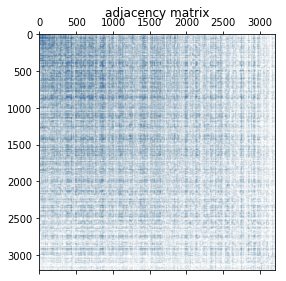

In [306]:
plt.spy(adjacency, markersize=0.01)
plt.title('adjacency matrix');
plt.tight_layout()

L_max = 5153655.0
L = 321554
Sparsity = 0.9376066112302822


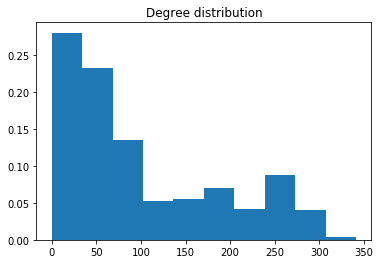

In [307]:
# maximum number of Links in our network
L_max = n_nodes*(n_nodes-1)/2
print('L_max =', L_max)

# number of link in our network
L = np.count_nonzero(adjacency)
print('L =',L)

# sparisty
sparsity = (L_max-L)/L_max
print('Sparsity =', sparsity)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary = adjacency.astype(bool).astype(int)
degree =  np.sum(adj_binary, axis=0)

#Histogram of degree distribution
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);
plt.title('Degree distribution');

In [308]:
def adj_matrix_to_list(adj):
    """Transform adjacency matrix into a dictionnary : each node is linked with all his neighbor nodes
    
    Parameters
    ----------
    adjacency matrix 
    
    Returns
    -------
    adj_list : dictionnary
    """
    
    adj_list = {} 
    for node, nodes in enumerate(adj):
        neighbors = []
        for next_node, weighted_edge in enumerate(nodes):
            if weighted_edge:
                neighbors.append(next_node)
        adj_list[node] = neighbors
    return adj_list

In [309]:
# The BFS algorithm
def bfs(adj_list, start, labels, l=1):
    
    """Apply the BFS algorithm 
    
    Parameters
    ----------
    adj_list: adjacency matrix transformed to a list (see ajd_matrix_to_list)
    start: Starting node
    labels : will contain the information whether a node has been visited or not
    
    Returns
    -------
    labels : contain the information whether a node has been visited or not
    bool connected : true if all the nodes are connected
    visited : a list of all the visited nodes
        True if the graph is connected, False otherwise.
    """
    
    
    nodes = list(labels.keys())
    #q is a queue, it contains the next node to be inspected (initialized with the starting node)
    q = []
    q.append(start)
    #label contains for each node l (if the node has already been inspected) or 0
    labels[start] = l
    
    #while there is nodes to inspect
    while len(q):
        node = q.pop(0)
        
        #inspect all the nodes linked to 'node'
        for neighbor in adj_list[node]: 
            #if it has not already been inspected, add it to the queue, and label it to 1
            if labels[neighbor] == 0: 
                q.append(neighbor)
                labels[neighbor] = l
    #contains all the connected nodes
    visited = {node: label for (node, label) in labels.items() if label !=0} 
    connected = len(visited) == len(nodes)
    return labels, connected, visited

In [310]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    components = list()
    # transform the adjacency matrix into an adjacency list where the weights are ignored
    adj_list = adj_matrix_to_list(adjacency) 
    
    # l: the label of the components
    l = 1
    
    # select a random node to start exploring the graph
    start = np.random.choice(list(adj_list.keys()))
    nodes = list(adj_list.keys())
    
    # apply BFS to label the nodes of the first component and to know if the graph is connected
    labels, visited_all, _ = bfs(adj_list, start, {node: 0 for node in nodes})
    visited = [node for node, label in labels.items() if label == l]
    components.append(adjacency[visited, :][:, visited]) 
    
    # while we did not label every node
    while not visited_all:
        l += 1
        to_visit = [node for node, label in labels.items() if label == 0]
        start = np.random.choice(list(to_visit))
        # apply new BFS to explore new component
        labels, visited_all,_ = bfs(adj_list, start, labels, l)
        visited = [node for node, label in labels.items() if label == l]
        components.append(adjacency[visited, :][:, visited]) 
    
    # the list of all components sorted by descending size 
    components.sort(key=lambda mat: mat.shape, reverse=True)    
    return components, labels

In [311]:
try:
    bc_nparray = np.load(data_path + 'BC.npy')
    nodes_bc = np.load(data_path + 'nodes_BC.npy')
    
except FileNotFoundError:
    components, labels = find_components(adjacency)
    bc_nparray = components[0]
    label_count = np.unique(np.fromiter(labels.values(), dtype=int), return_counts=True)
    lab_dict = dict(zip(label_count[0], label_count[1]))
    label_bc = max(lab_dict, key=lab_dict.get)
    nodes_bc = [node for node, label in labels.items() if label == label_bc]
    np.save(data_path + 'BC.npy', BC_nparray)
    np.save(data_path + 'nodes_bc.npy', nodes_bc)

n_nodes_bc = len(nodes_bc)
print('The size of the largest component is {}.'.format(n_nodes_bc))

The size of the largest component is 3145.


In [312]:
G = nx.from_numpy_array(bc_nparray)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G))

Clustering coefficient of our Biggest Component = 0.5421199049721809


In [313]:
movies_bc = movies.loc[nodes_bc, :]
movies_bc['earnings'].describe()

count     3145.000000
mean         9.934463
std        242.103785
min         -0.999744
25%          0.058528
50%          1.325575
75%          3.421053
max      12889.386667
Name: earnings, dtype: float64

In [314]:
degree_biggest_component= np.sum(bc_nparray, axis=0)

N = n_nodes_bc  # number of nodes
E = np.sum(bc_nparray > 0)  # number of edges (non-zero entries of A)

try:
    gradient = scipy.sparse.load_npz(data_path + 'gradient.npz')
    sparse_gradient = sparse.csr_matrix(gradient)
    
except FileNotFoundError:
    # Let us compute the gradient
    gradient = np.zeros((E, N))
    eij = 0  # edge index

    for i in range(N):
        for j in range(N):
            wij = bc_nparray[i, j]
            if wij > 0:
                gradient[eij,i] = math.sqrt(wij)/math.sqrt(2*degree_biggest_component[i])
                gradient[eij,j] = -math.sqrt(wij)/math.sqrt(2*degree_biggest_component[j])
                eij = eij + 1  # increment the edge index 
    sparse_gradient = sparse.csr_matrix(gradient)
    scipy.sparse.save_npz(data_path + 'gradient.npz', sparse_gradient)
    
laplacian = (gradient.T@gradient) #Laplacian Normalisé calculé avec le gradient.

sparse_laplacian = sparse.csr_matrix(laplacian)

In [315]:
eigenvalues, eigenvectors = np.linalg.eigh(sparse_laplacian.toarray())
e = eigenvalues
U = eigenvectors

D = np.diag(degree_biggest_component)
D_inv = np.divide(1,D)
D_inv[D_inv == np.inf] = 0
D_sqrtinv = scipy.linalg.sqrtm(D_inv)

#Renormalized by the degrees
U_norm = D_sqrtinv@U

# Normalize the rows of U_norm
rows_norm = np.linalg.norm(U_norm, axis=1, ord=2)
U_norm = (U_norm.T / rows_norm).T

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


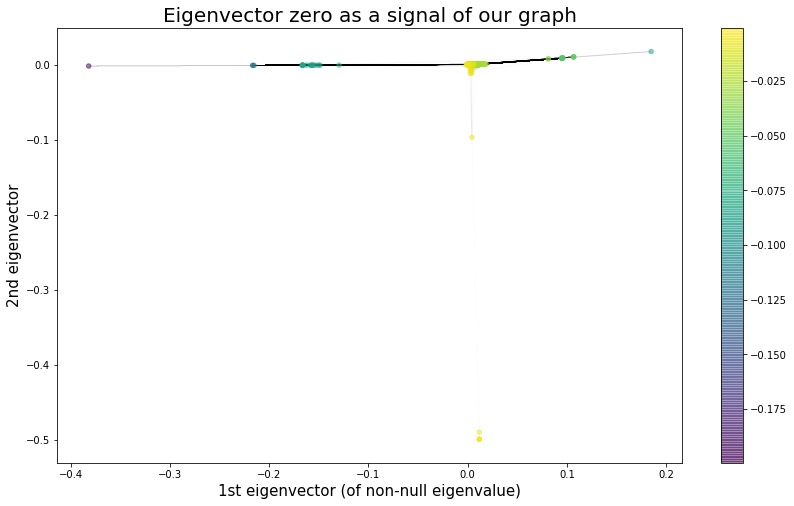

In [316]:
plt.figure(figsize=(14,8))
coords = U_norm[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5, node_size=20, node_color=U_norm[:,0])
nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

In [359]:
def GFT(x,N,U_norm):
    gft = np.zeros(N)
    for i in range(N):
        gft[i] = np.dot(x,U_norm[:,i])
    return gft 

def iGFT(x,N,U_norm):
    igft = np.zeros(N)
    for i in range(N):
            igft[i] += np.dot(x,U_norm[i,:])
    return igft

In [318]:
label_threshold = 2

In [319]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation(threshold):
    labels = np.zeros(n_nodes_bc, dtype=float)
    labels[movies_bc['earnings'] >= threshold] = 1
    labels[movies_bc['earnings'] < threshold] = -1
    return labels

In [320]:
labels_bc = labels_creation(label_threshold)
lab_bc_count = np.unique(labels_bc, return_counts=True)
dict(zip(lab_bc_count[0], lab_bc_count[1]))

{-1.0: 1891, 1.0: 1254}

<StemContainer object of 3 artists>

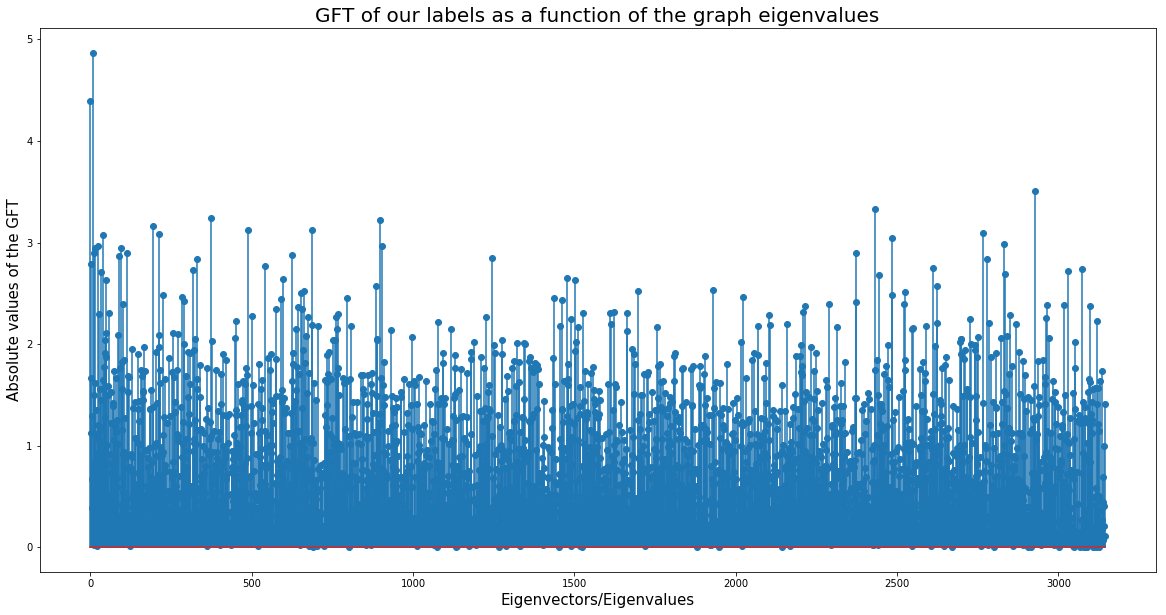

In [321]:
gft = GFT(labels_bc,N,U_norm)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)
#plt.arrow(1000, 10, -860, 12, color ='r', head_width = 0.5, head_length = 25)

In [322]:
index_eig = gft.argsort()[-10:][::-1]

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


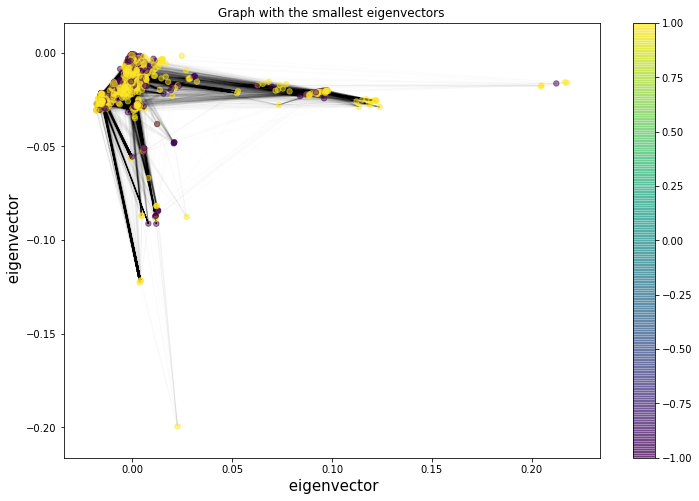

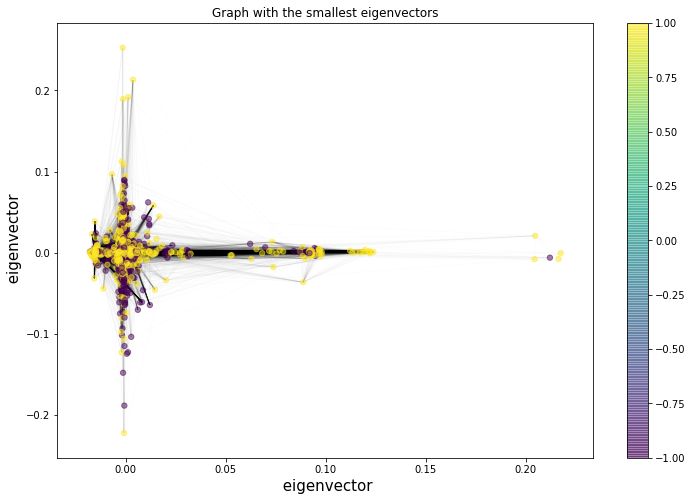

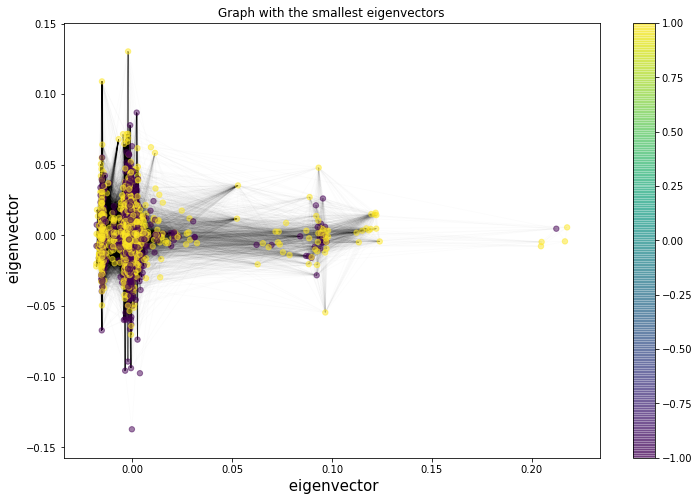

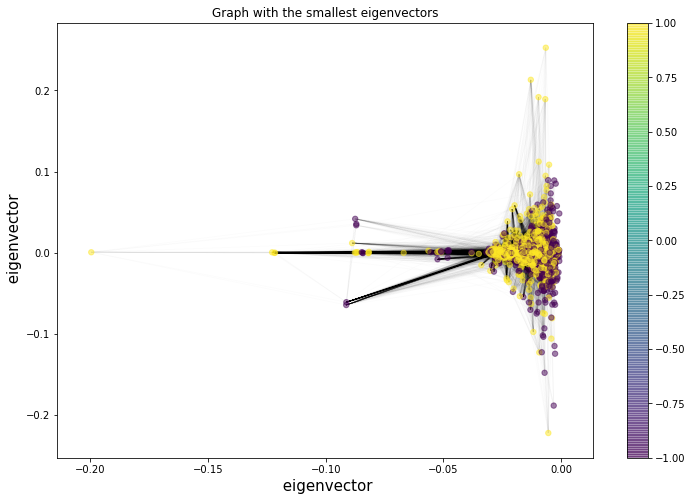

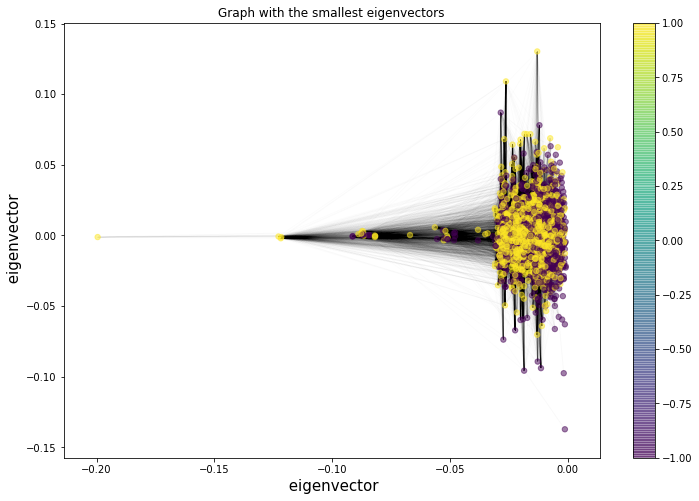

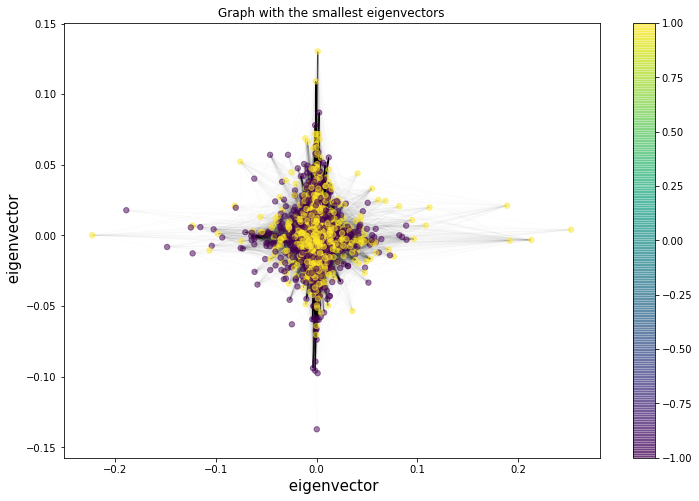

In [323]:
for i in range(4):
    for j in range(i+1,4):
        plt.figure(figsize=(12,8))
        coords = U_norm[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5 ,node_size=29, node_color=labels_bc)
        nx.draw_networkx_edges(G, coords, alpha=0.01)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

Mettre plusieurs graph avec des differents tresholds et dire que on peut rien voir. Expliquer des possibles raisons, etc etc... BULLSHIT





# 2. Second Graph Construction: BRH Model

As we could see in the previous section, we were not able to extract any remarkable information using the `weights` obtained with the previously introduced mathematical model. Therefore, we decided to create a novel way of computing an index that represents somehow the economical impact that an actor/character/director/company has when participating in a movie production. 

In order to do so, we were inspired by the mathematical model "h-index" used in the scientific community to measure the impact of the creations (papers) of a scientist. 

We named our model: BRH-Index. This one attempts to better represent the 



## 2.1 Compute BRH Index

In [ ]:
# BRH_index created and owned by BRH Index Corp. MIT License. For business inquires, please contact our secretary Romain Abruti
def brh_index_calculator(name):
    
    
    """Apply the BRH index algorithm 
    
    Parameters
    ----------
    name: name of the actor/character/production company
    
    Returns
    -------
    brh_index : quantify the impact of a feature as a function of the revenue of the films in which it was involved
 
    """
    
    
    brh_index = 0
    brh_index_p = 0
    brh_index_n = 0
    
    earnings_df = pd.DataFrame(df[df['feature'] == name]['earnings'])
    
    positive_earnings = earnings_df[earnings_df > 0].dropna().sort_values(['earnings'], ascending = False)
    positive_earnings = 100*positive_earnings.reset_index(drop=True)



    if (len(positive_earnings['earnings']) == 1):
        if (positive_earnings['earnings'][0] >= 1):
            brh_index_p = 1
        else:
            brh_index_p = round(positive_earnings['earnings'][0])
    else:
        for i in range(len(positive_earnings['earnings'])) :
            if len(positive_earnings[positive_earnings['earnings'] >= positive_earnings['earnings'][i]]) >= round(positive_earnings['earnings'][i]) :
                brh_index_p = i
                break
        

    negative_earnings = earnings_df[earnings_df < 0].dropna().sort_values(['earnings'], ascending = True)
    negative_earnings = negative_earnings.reset_index(drop=True)
    negative_earnings = 100* abs(negative_earnings)

    if (len(negative_earnings['earnings']) == 1):
        if (negative_earnings['earnings'][0] >= 1):
            brh_index_n = 1
        else:
            brh_index_n = round(negative_earnings['earnings'][0])
    else:
        for i in range(len(negative_earnings['earnings'])) :
            if len(negative_earnings[negative_earnings['earnings'] >= negative_earnings['earnings'][i]]) >= round(negative_earnings['earnings'][i]) :
                brh_index_n = i
                break
        

    brh_index = brh_index_p - brh_index_n
    return brh_index

In [ ]:
features['brh_index'] = 0

for i, feature in enumerate(features['feature']):
    features.loc[i, 'brh_index'] = brh_index_calculator(feature)

In [295]:
brh_index_calculator('Brad Pitt')

27

In [ ]:
features['brh_index'] = features['brh_index'] + 10
features.sort_values(by='brh_index', ascending=False)
features[features['feature'] == 'James Bond']

In [337]:
features.sort_values(by='brh_index', ascending=False)

,feature,weight,brh_index
19237,Universal Pictures,3.901744,123.0
14659,Paramount Pictures,4.439880,114.0
19133,Twentieth Century Fox Film Corporation,3.778530,105.0
3799,Columbia Pictures,1.878315,94.0
14089,New Line Cinema,8.538247,81.0
19571,Walt Disney Pictures,2.663880,72.0
19235,United Artists,10.830685,59.0
5502,DreamWorks SKG,2.315972,47.0
6525,Fox Searchlight Pictures,4.725724,45.0
19425,Village Roadshow Pictures,1.475530,42.0


In [339]:
features[features['feature'] == 'Sam']['brh_index'].item()

0.0

# Compute Adjacency Matrix

In [342]:
n_nodes = len(movies)

try:
    adjacency_brh = np.load(data_path + 'adjacency_brh.npy')

except FileNotFoundError: 
    adjacency_brh = np.zeros((n_nodes, n_nodes), dtype=int)
    for i in range(n_nodes):
            # as the adjacency matrix is symmetric, only the upper triangular is calculated to save time
            for j in range(i, n_nodes):
                # create weighted edges as the shared number of actors between movies
                common_actors = set(movies['features'][i]).intersection(set(movies['features'][j]))
                sum_brh_indexes = 0.0

                for name in common_actors :
                    if (features['feature'].isin([name]).any()):
                        sum_brh_indexes = sum_brh_indexes + features[features['feature'] == name]['brh_index'].item()
                

                adjacency_brh[i, j] = sum_brh_indexes
      
    # fill the lower triangular 
    adjacency_brh += np.transpose(adjacency_brh)

    np.fill_diagonal(adjacency_brh, 0, wrap=False)
    np.save(data_path + 'adjacency_brh.npy', adjacency_brh)

L_max = 5153655.0
L = 321554
Sparsity = 0.934845075970355


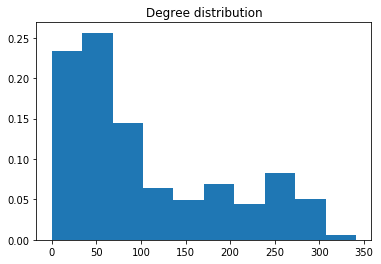

In [345]:
# maximum number of Links in our network
L_max_brh = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh)

# number of link in our network
L_brh = np.count_nonzero(adjacency_brh)
print('L =',L)

# sparisty
sparsity_brh = (L_max_brh-L_brh)/L_max_brh
print('Sparsity =', sparsity_brh)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh = adjacency_brh.astype(bool).astype(int)
degree_brh =  np.sum(adj_binary_brh, axis=0)

#Histogram of degree distribution
weights_brh = np.ones_like(degree_brh) / float(n_nodes)
plt.hist(degree_brh, weights=weights_brh);
plt.title('Degree distribution');

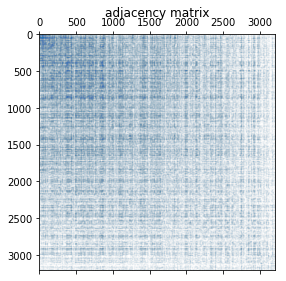

In [346]:
plt.spy(adjacency_brh, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

In [347]:
try:
    bc_nparray_brh = np.load(data_path + 'BC_brh.npy')
    nodes_bc_brh = np.load(data_path + 'nodes_BC_brh.npy')
    
except FileNotFoundError:
    components_brh, labels_brh = find_components(adjacency_brh)
    bc_nparray_brh = components_brh[0]
    label_count_brh = np.unique(np.fromiter(labels_brh.values(), dtype=int), return_counts=True)
    lab_dict_brh = dict(zip(label_count_brh[0], label_count_brh[1]))
    label_bc_brh = max(lab_dict_brh, key=lab_dict_brh.get)
    nodes_bc_brh = [node for node, label in labels_brh.items() if label == label_bc_brh]
    np.save(data_path + 'BC_brh.npy', bc_nparray_brh)
    np.save(data_path + 'nodes_bc_brh.npy', nodes_bc_brh)

n_nodes_bc_brh = len(nodes_bc_brh)
print('The size of the largest component is {}.'.format(n_nodes_bc_brh))

The size of the largest component is 3183.


In [348]:
G_brh = nx.from_numpy_array(bc_nparray_brh)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_brh))

Clustering coefficient of our Biggest Component = 0.48686154852153357


In [349]:
movies_bc_brh = movies.loc[nodes_bc_brh, :]
movies_bc_brh['earnings'].describe()

count     3183.000000
mean         9.813127
std        240.656376
min         -0.999744
25%          0.030258
50%          1.300522
75%          3.379592
max      12889.386667
Name: earnings, dtype: float64

In [350]:
degree_biggest_component_brh= np.sum(bc_nparray_brh, axis=0)

degree_biggest_component_brh

array([  723,  8203, 16240, ...,  2680,   107, 15530])

In [352]:
degree_biggest_component_brh= np.sum(bc_nparray_brh, axis=0)

N_brh = n_nodes_bc_brh  # number of nodes
E_brh = np.sum(bc_nparray_brh > 0)  # number of edges (non-zero entries of A)

try:
    gradient_brh = scipy.sparse.load_npz(data_path + 'gradient_brh.npz')
    sparse_gradient_brh = sparse.csr_matrix(gradient_brh)
    
except FileNotFoundError:
    # Let us compute the gradient
    gradient_brh = np.zeros((E_brh, N_brh))
    eij_brh = 0  # edge index

    for i in range(N_brh):
        for j in range(N_brh):
            wij_brh = bc_nparray_brh[i, j]
            if wij_brh > 0:
                gradient_brh[eij_brh,i] = math.sqrt(wij_brh)/math.sqrt(2*degree_biggest_component_brh[i])
                gradient_brh[eij_brh,j] = -math.sqrt(wij_brh)/math.sqrt(2*degree_biggest_component_brh[j])
                eij_brh = eij_brh + 1  # increment the edge index 
    sparse_gradient_brh = sparse.csr_matrix(gradient_brh)
    scipy.sparse.save_npz(data_path + 'gradient_brh.npz', sparse_gradient_brh)
    
laplacian_brh = (gradient_brh.T@gradient_brh) #Laplacian Normalisé calculé avec le gradient.

sparse_laplacian_brh = sparse.csr_matrix(laplacian_brh)

In [397]:
sum(laplacian_brh)

array([ 0.16249892, -0.13680433, -0.10520098, ...,  0.00642429,
        0.63584852,  0.02107703])

In [353]:
eigenvalues_brh, eigenvectors_brh = np.linalg.eigh(sparse_laplacian_brh.toarray())
e_brh = eigenvalues_brh
U_brh = eigenvectors_brh

D_brh = np.diag(degree_biggest_component_brh)
D_inv_brh = np.divide(1,D_brh)
D_inv_brh[D_inv_brh == np.inf] = 0
D_sqrtinv_brh = scipy.linalg.sqrtm(D_inv_brh)

#Renormalized by the degrees
U_norm_brh = D_sqrtinv_brh@U_brh

# Normalize the rows of U_norm
rows_norm_brh = np.linalg.norm(U_norm_brh, axis=1, ord=2)
U_norm_brh = (U_norm_brh.T / rows_norm_brh).T

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


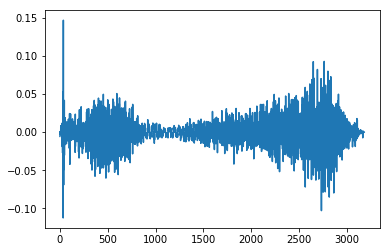

In [395]:
plt.plot(eigenvectors_brh[0])

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


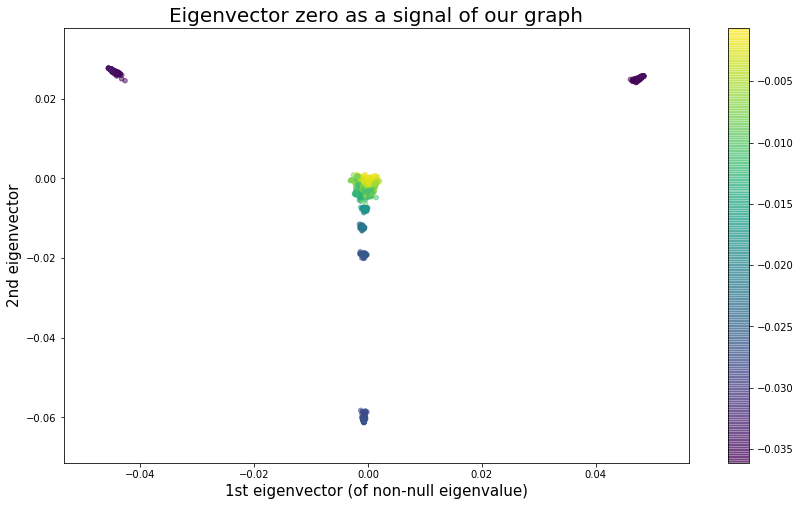

In [379]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=U_norm_brh[:,0])
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


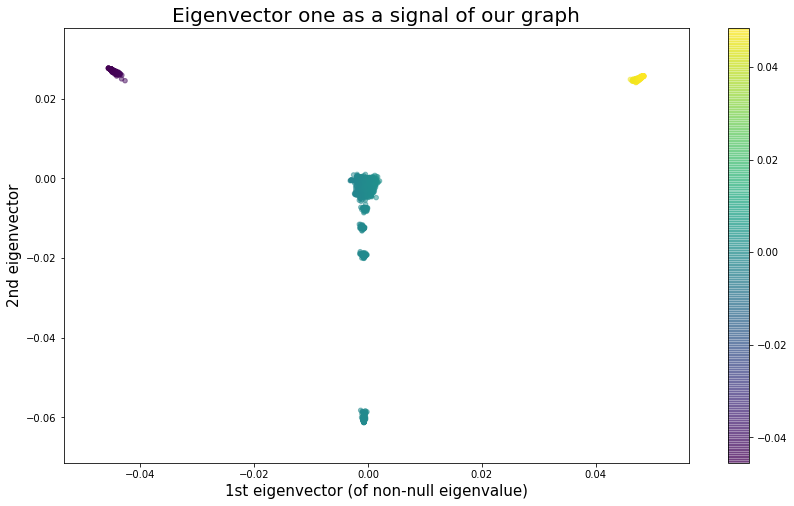

In [386]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=U_norm_brh[:,1])
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Eigenvector one as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


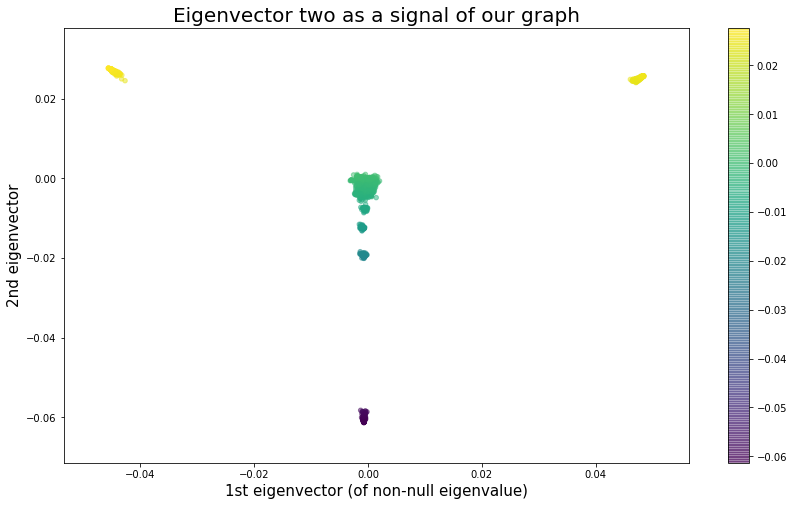

In [387]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=U_norm_brh[:,2])
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Eigenvector two as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

In [369]:
label_threshold = 5

In [371]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh(threshold):
    labels = np.zeros(n_nodes_bc_brh, dtype=float)
    labels[movies_bc_brh['earnings'] >= threshold] = 1
    labels[movies_bc_brh['earnings'] < threshold] = -1
    return labels

In [372]:
labels_bc_brh = labels_creation_brh(label_threshold)
lab_bc_count_brh = np.unique(labels_bc_brh, return_counts=True)
dict(zip(lab_bc_count_brh[0], lab_bc_count_brh[1]))

{-1.0: 2644, 1.0: 539}

<StemContainer object of 3 artists>

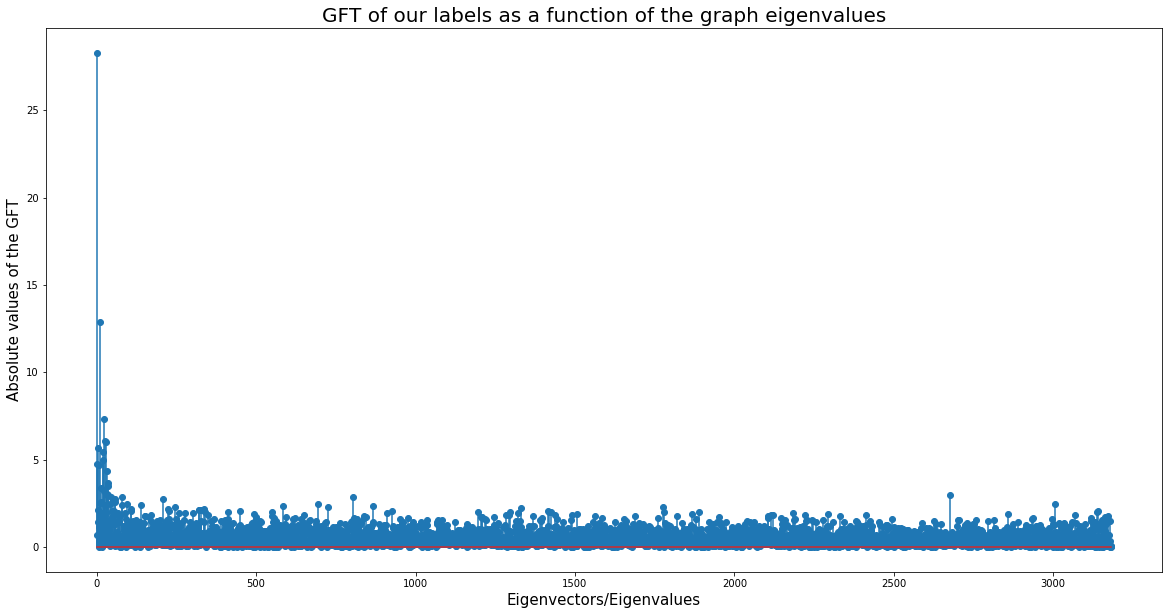

In [373]:
gft = GFT(labels_bc_brh, N_brh, U_norm_brh)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)
#plt.arrow(1000, 10, -860, 12, color ='r', head_width = 0.5, head_length = 25)

In [376]:
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([ 0,  9, 23, 26, 28,  3, 20, 21,  2,  7], dtype=int64)

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


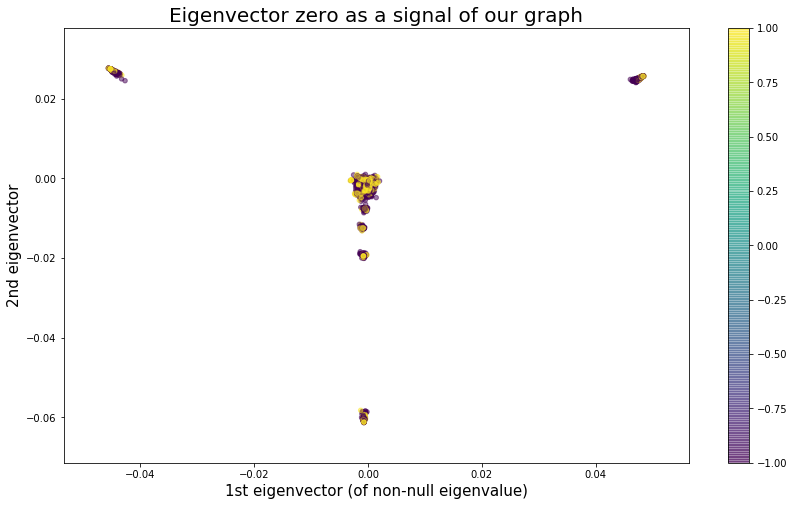

In [380]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh)
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

C:\Users\rocar\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


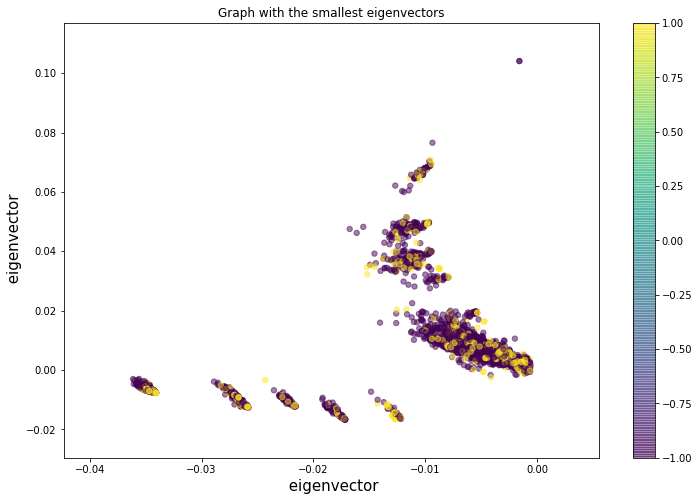

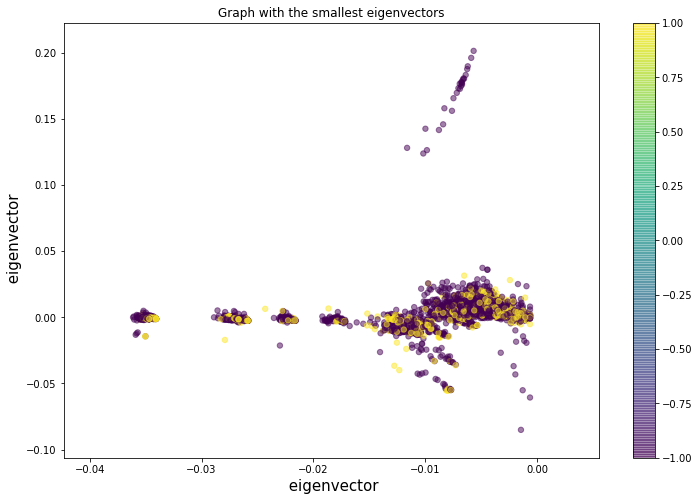

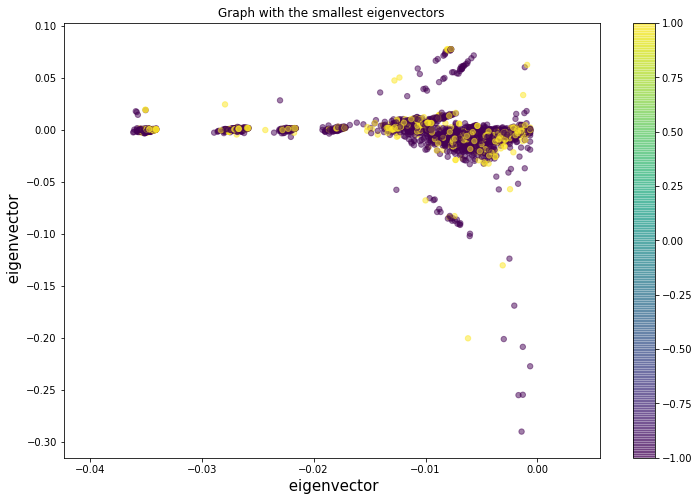

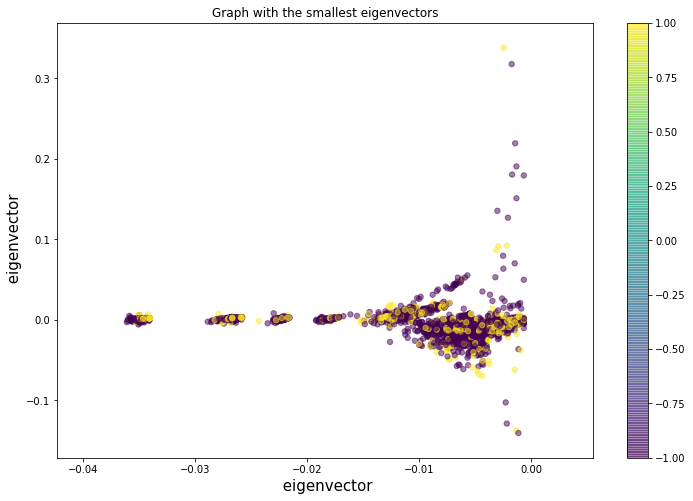

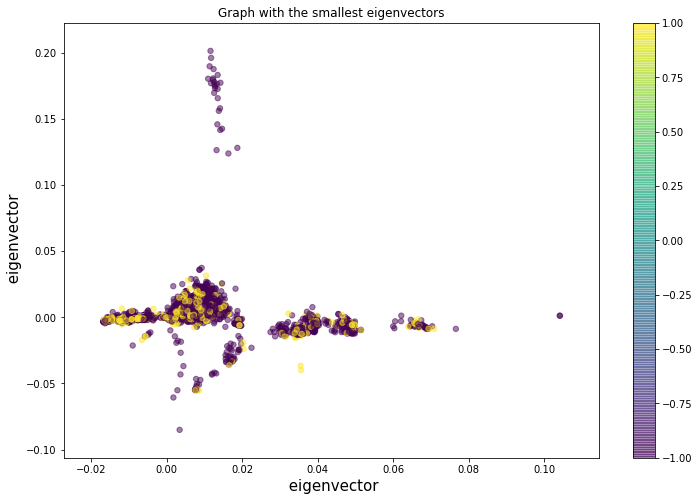

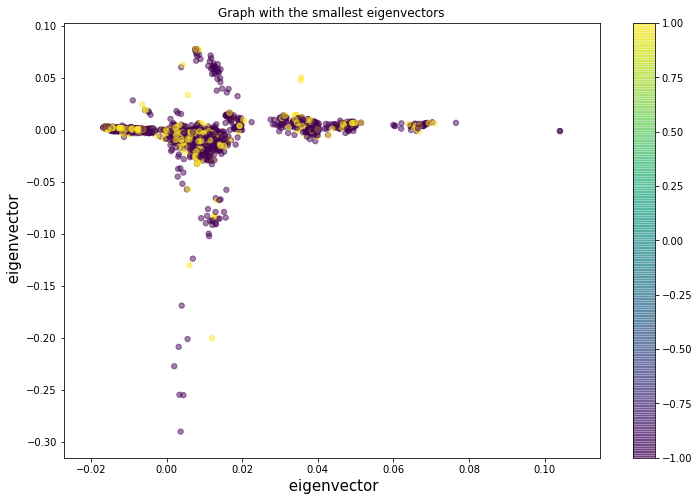

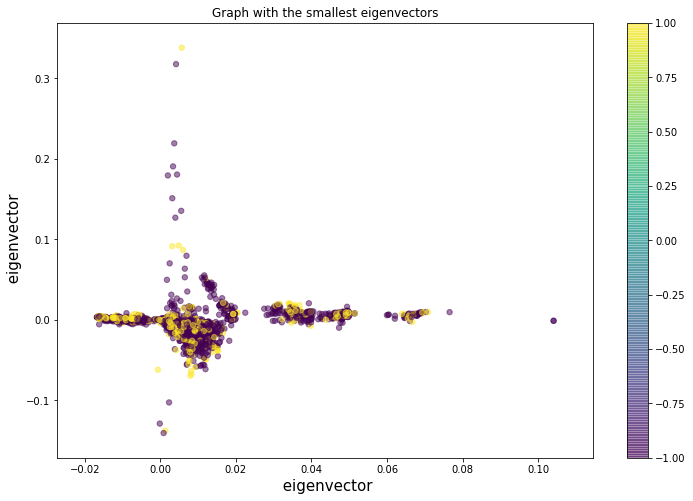

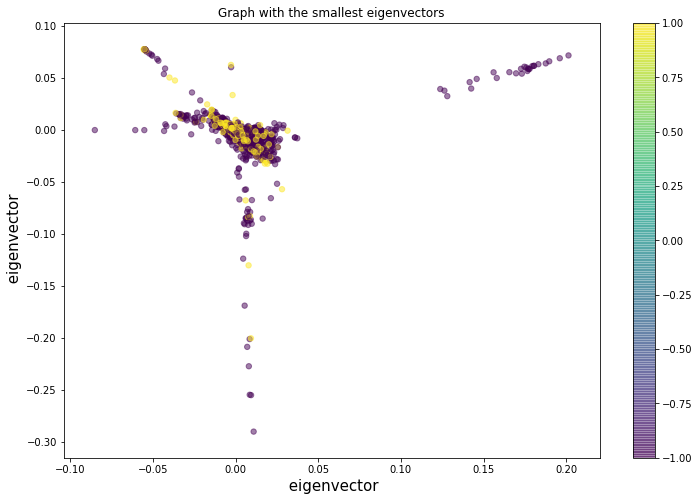

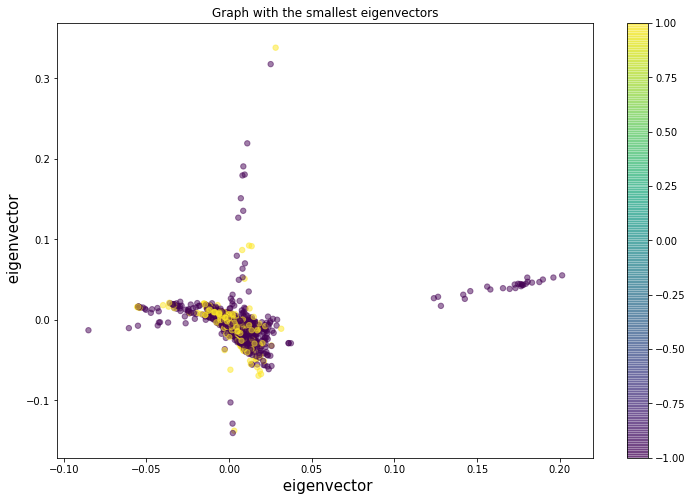

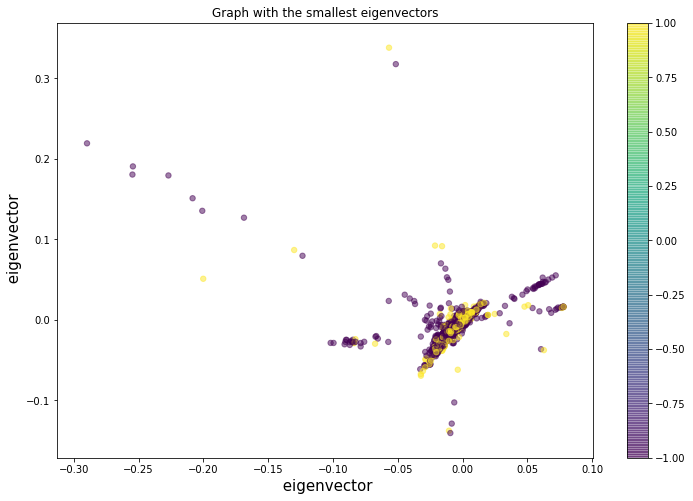

In [381]:
for i in range(5):
    for j in range(i+1,5):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh)
        nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);